In [1]:
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point
from fiona.crs import from_epsg

import pytz, datetime

import sqlite3

In [2]:
kw = pd.read_csv("kali/data/kismet_wigle_20200616.csv", skiprows = 1)
kw.rename(columns = {"MAC" : "mac", "SSID" : "ssid", "Channel" : "ch", "RSSI" : "rssi", 
                     "CurrentLatitude" : "lat", "CurrentLongitude" : "lon", 
                     "AltitudeMeters" : "alt", "AccuracyMeters" : "acc", "Type" : "type", 
                     "FirstSeen" : "time"}, 
          inplace = True)

kw.time = pd.to_datetime(kw.time).dt.tz_localize('utc').dt.tz_convert(pytz.timezone('US/Central'))

gkw = gpd.GeoSeries([Point(xy) for xy in kw[["lon", "lat"]].values], crs = from_epsg(4326)).to_crs(epsg = 3528)
kw = gpd.GeoDataFrame(data = kw, geometry = gkw, crs = from_epsg(3528))

In [3]:
kw.mac.shape[0], kw.mac.unique().shape[0]

(80761, 4330)

This looks right -- got the power fixed???

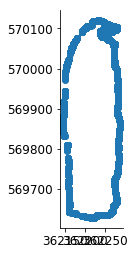

In [4]:
kw.plot()

In [5]:
! sqlite3 kali/data/kismet_200616.sqlite <<< ".schema"

CREATE TABLE KISMET (kismet_version TEXT, db_version INT, db_module TEXT);
CREATE TABLE devices (first_time INT, last_time INT, devkey TEXT, phyname TEXT, devmac TEXT, strongest_signal INT, min_lat REAL, min_lon REAL, max_lat REAL, max_lon REAL, avg_lat REAL, avg_lon REAL, bytes_data INT, type TEXT, device BLOB, UNIQUE(phyname, devmac) ON CONFLICT REPLACE);
CREATE TABLE packets (ts_sec INT, ts_usec INT, phyname TEXT, sourcemac TEXT, destmac TEXT, transmac TEXT, frequency REAL, devkey TEXT, lat REAL, lon REAL, alt REAL, speed REAL, heading REAL, packet_len INT, signal INT, datasource TEXT, dlt INT, packet BLOB, error INT, tags TEXT);
CREATE TABLE data (ts_sec INT, ts_usec INT, phyname TEXT, devmac TEXT, lat REAL, lon REAL, alt REAL, speed REAL, heading REAL, datasource TEXT, type TEXT, json BLOB );
CREATE TABLE datasources (uuid TEXT, typestring TEXT, definition TEXT, name TEXT, interface TEXT, json BLOB, UNIQUE(uuid) ON CONFLICT REPLACE);
CREATE TABLE alerts (ts_sec INT, ts_usec INT, p

In [6]:
devices_sql = """
SELECT 
  json_extract(device, '$."dot11.device"."dot11.device.last_beaconed_ssid_record"."dot11.advertisedssid.ssid"') ssid, 
  devmac, 
  strongest_signal signal, 
  (first_time + last_time) / 2 time, 
  avg_lat lat, avg_lon lon 
FROM
  devices 
WHERE 
  avg_lat > 0 AND 
  type = 'Wi-Fi AP' 
ORDER BY 
  signal DESC
;
"""

In [7]:
con = sqlite3.connect("kali/data/kismet_200616.sqlite")
dev = pd.read_sql(devices_sql, con)

dev.time = pd.to_datetime(dev.time, unit='s', origin='unix')\
             .dt.tz_localize('utc').dt.tz_convert(pytz.timezone('US/Central'))
    
dev = gpd.GeoDataFrame(data = dev, crs = from_epsg(3528), geometry = \
                       gpd.GeoSeries([Point(xy) for xy in dev[["lon", "lat"]].values], 
                                     crs = from_epsg(4326)).to_crs(epsg = 3528))

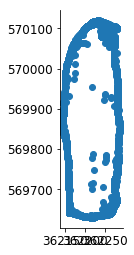

In [8]:
dev.plot()